
[RAPID2018](https://rapid2018.org/)


# [RAMP](https://www.ramp.studio/problems/mars_craters) on Primary Vertex reconstruction



1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)
3. [Workflow](#Workflow)
4. [Evaluation](#Scoring)
5. [Local testing/exploration](#Local-testing)
6. [Submission](#Submitting-to-ramp.studio)

## Introduction


### The prediction task



### References



## Preprocessing



With no further do, let's have a look at the data.

### Required dependencies and downloads

#### Installation of libraries and `ramp-workflow`

To get this notebook running and test your models locally using the `ramp_test_submission`, we recommend that you use the Python distribution from [Anaconda](https://www.anaconda.com/download/) or [Miniconda](https://conda.io/miniconda.html). 

In [3]:
# !conda env create -f environment.yml   # use the environment.yml file to create the 'mars-craters' env
# !source activate vertex_finding          # activate the virtual environment

**OR** if you have Python already installed but are **not using Anaconda**, you'll want to use `pip` 

In [4]:
# !pip install -r requirements.txt

#### Download script (optional)

If the data has not yet been downloaded locally, uncomment the following cell and run it.

There are ~700Mb of images.

In [5]:
# !python download_data.py

#### The input data
The input data consists of a json file for each event (where an event is a bunch crossing).
The json file contains the hits in the Velo detector, Velo states from a simplified Kalman filter of the reconstructed Velo tracks, as well as the MC truth information.

In [6]:
import json
from matplotlib import pyplot as plt
from pprint import pprint

In [7]:
jdata = json.load(open('data/train/RapidVPData_6918078_578252.json'))
for key in jdata:
    print(key)

MCVertices
EventNumber
RunNumber
MCParticles
VPClusters
VeloTracks


We are interested in the reconstructed hits and tracks

In [8]:
VeloTracks  = jdata['VeloTracks']
VeloHits  = jdata['VPClusters']

The hits are made of (x,y,z) coordinates:

In [9]:
key = '2147516400'
hit = VeloHits[key]
pprint(hit)
print (hit['x'], hit['y'], hit['z'])

{u'MCPs': [u'9386'],
 u'key': u'2147516400',
 u'x': 17.327651977539062,
 u'y': -25.745758056640625,
 u'z': -288.08099365234375}
(17.327651977539062, -25.745758056640625, -288.08099365234375)


Velo tracks consist of states (x,y,z,tx,ty,p/q) and a covariance matrix

In [10]:
track = VeloTracks['0']
pprint(track)

{u'ClosestToBeam': [-0.7562400893639847,
                    -0.15443361936862843,
                    -57.72109603881836,
                    0.0027981847524642944,
                    -0.009495257399976254,
                    0.0],
 u'LHCbIDs': [u'2195200252', u'2197296116', u'2199392236', u'2201488356'],
 u'MCPs': [u'8482'],
 u'errCTBState': [0.019834144206224584,
                  0.019834144206224584,
                  3.97577828437079e-08,
                  3.97577828437079e-08,
                  -2.801031684519636e-05],
 u'isBackwards': False,
 u'key': u'0'}


We can, for example, pltos the x-y distribution of all hits:

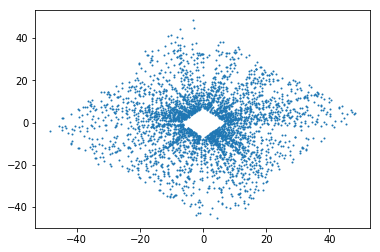

In [11]:
hits_x = [item['x'] for  key, item in VeloHits.items()]
hits_y = [item['y'] for  key, item in VeloHits.items()]
plt.plot(hits_x,hits_y, 'o', markersize=1.)

or z distribution

(array([637., 118., 368., 545., 529., 392., 127., 122., 175., 289.]),
 array([-288.08099365, -184.21479492,  -80.34859619,   23.51760254,
         127.38380127,  231.25      ,  335.11619873,  438.98239746,
         542.84859619,  646.71479492,  750.58099365]),
 <a list of 10 Patch objects>)

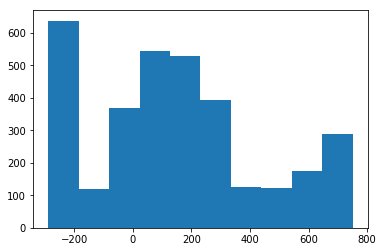

In [12]:
hits_z = [item['z'] for  key, item in VeloHits.items()]
plt.hist(hits_z)

The data is transformed from the json format to a (hopefully) more convenient form:

In [13]:
import problem

In [14]:
X, y = problem.get_train_data('.')

X contains the training/test data, y the truth information.

In [22]:
X.shape

(4997,)

In [23]:
print(X)

[EventData EventData EventData ... EventData EventData EventData]


There are a couple of helper classes to organize the data.
The test and train data X is a numpy array of object of type EventData. Let' have a closer look at this helper class:

In [24]:
event = X[0]

It contains the two members, hits and tracks, which are lists containing the Velo hits and states, respectively, again using helper classes:

In [25]:
event.hits[0:5]

[VeloHit(-0.853830337524, -13.164560318, -138.080993652),
 VeloHit(21.2538642883, 12.5635204315, 325.580993652),
 VeloHit(7.63557434082, -0.756603240967, 700.580993652),
 VeloHit(18.3759384155, -19.0936527252, -200.580993652),
 VeloHit(-15.1002645493, -30.2641716003, 238.080993652)]

In [26]:
event.tracks[0:5]

[VeloState(-0.0370322333154,-0.0465060999728,-69.7914962769,-0.0489471331239,0.0375521630049),
 VeloState(0.0828115966481,0.138106270306,5.5852060318,-0.0756436511874,0.0397497005761),
 VeloState(0.0359277018182,0.0392959005628,5.69606018066,-0.0520540960133,0.0548235811293),
 VeloState(0.0619594416191,0.0650754783462,4.07017993927,-0.0426263771951,0.0352761521935),
 VeloState(-0.0535529908645,-0.0374068879655,4.25565099716,-0.0212026815861,0.0327544286847)]

The VeloHit class just holds the x,y,z coordinates of the hit:

In [27]:
hit = event.hits[0]
print (hit)
print(hit.x, hit.y, hit.z)

VeloHit(-0.853830337524, -13.164560318, -138.080993652)
(-0.8538303375244141, -13.164560317993164, -138.08099365234375)


The VeloTrack helper class holds the state (x,y,z,tx,ty,p/q) of a simplified Kalman fit of the track, as well as the corresponding covariance matrix:

In [28]:
track = event.tracks[0]
print(track)
print("track state:")
print("x:", track.x)
print("y:", track.y)
print("z:", track.z)
print("tx:", track.tx)
print("ty:", track.ty)
print("pq:", track.pq)

print("covariance matrix:")
print("cov x:", track.cov_x)
print("cov y:", track.cov_y)
print("cov tx:", track.cov_tx)
print("cov ty:", track.cov_ty)
print("cov xtx:", track.cov_xtx)



VeloState(-0.0370322333154,-0.0465060999728,-69.7914962769,-0.0489471331239,0.0375521630049)
track state:
('x:', -0.03703223331541494)
('y:', -0.04650609997281663)
('z:', -69.79149627685547)
('tx:', -0.048947133123874664)
('ty:', 0.03755216300487518)
('pq:', 0.0)
covariance matrix:
('cov x:', 0.0033649414069035753)
('cov y:', 0.0033649414069035753)
('cov tx:', 1.390033901316201e-07)
('cov ty:', 1.390033901316201e-07)
('cov xtx:', 2.1295523651936e-05)


It should be noted that the p/q is always zero, since we have no momentum estimate from the Velo Kalman fit.
The covariance matrix consist of the diagonal elements x, y, tx, ty and the off-diagonal element xtx. The Velo Kalman fit contains some simplifications, resulting that the covariance element for x and y is always equal. The same is true for the xtx and yty elements

Again, we can make plots:

In [29]:
hits_x = [hit.x for hit in event.hits]
hits_y = [hit.y for hit in event.hits]
hits_z = [hit.z for hit in event.hits]

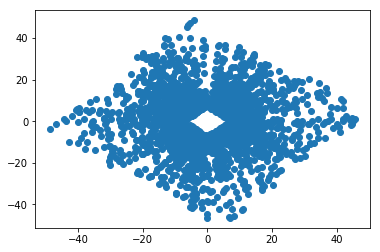

In [30]:
plt.plot(hits_x, hits_y, 'o')

(array([370.,  73., 263., 373., 322., 267.,  86.,  88., 139., 226.]),
 array([-288.08099365, -184.21479492,  -80.34859619,   23.51760254,
         127.38380127,  231.25      ,  335.11619873,  438.98239746,
         542.84859619,  646.71479492,  750.58099365]),
 <a list of 10 Patch objects>)

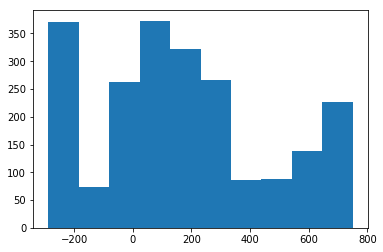

In [31]:
plt.hist(hits_z)

The MC truth PVs are saved in the following format: A numpy array containing a list for each event, where a lists contains all MC vertices of that event

In [39]:
y.shape


(4997,)

In [40]:
y[0]

[MCVertex, MCVertex, MCVertex, MCVertex, MCVertex, MCVertex, MCVertex]

In [41]:
mcvertex = y[0][0]

The MC vertex consists of its (x,y,z)-position and the number of tracks originating from it, which leave hits in the Velo

In [46]:
print "MC vertex x: ", mcvertex.x
print "MC vertex y: ", mcvertex.y
print "MC vertex z: ", mcvertex.z
print "MC vertex number of Velo tracks: ", mcvertex.numberTracks

MC vertex x:  -0.004
MC vertex y:  -0.0131
MC vertex z:  -69.1437
MC vertex number of Velo tracks:  6
